In [126]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import yfinance as yf

from datetime import datetime
import itertools as it
from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

import wrangle

In [127]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

## First I will acquire and prep the data for modeling

In [128]:
# use a function to pull in data
nem, nem_hr, holo, holo_hr = wrangle.get_crypto_data()
nem.shape, nem_hr.shape, holo.shape, holo_hr.shape

((1537, 6), (1091, 6), (1365, 6), (1091, 6))

In [129]:
# use a function to split daily data for NEM
nem_train, nem_validate, nem_test = wrangle.split_time_series_data(nem)

# use a function to split hourly data for NEM
nem_hr_train, nem_hr_validate, nem_hr_test = wrangle.split_time_series_data(nem_hr)

# use a function to split daily data for HOLO
holo_train, holo_validate, holo_test = wrangle.split_time_series_data(holo)

# use a function to split hourly data for HOLO
holo_hr_train, holo_hr_validate, holo_hr_test = wrangle.split_time_series_data(holo_hr)

In [130]:
# drop columns that will not be used in the prediction
# NEM daily data
nem_train, nem_validate, nem_test = pd.DataFrame(nem_train['Close']),\
                                    pd.DataFrame(nem_validate['Close']),\
                                    pd.DataFrame(nem_test['Close'])
# NEM hourly data
nem_hr_train, nem_hr_validate, nem_hr_test = pd.DataFrame(nem_hr_train['Close']),\
                                             pd.DataFrame(nem_hr_validate['Close']),\
                                             pd.DataFrame(nem_hr_test['Close'])
# HOLO daily data
holo_train, holo_validate, holo_test = pd.DataFrame(holo_train['Close']),\
                                       pd.DataFrame(holo_validate['Close']),\
                                       pd.DataFrame(holo_test['Close'])
# HOLO hourly data
holo_hr_train, holo_hr_validate, holo_hr_test = pd.DataFrame(holo_hr_train['Close']),\
                                                pd.DataFrame(holo_hr_validate['Close']),\
                                                pd.DataFrame(holo_hr_test['Close'])

In [131]:
nem_train.shape, nem_validate.shape, nem_test.shape, nem_hr_train.shape, nem_hr_validate.shape, nem_hr_test.shape, holo_train.shape, holo_validate.shape, holo_test.shape, holo_hr_train.shape, holo_hr_validate.shape, holo_hr_test.shape

((768, 1),
 (461, 1),
 (308, 1),
 (545, 1),
 (327, 1),
 (219, 1),
 (682, 1),
 (409, 1),
 (274, 1),
 (545, 1),
 (327, 1),
 (219, 1))

In [132]:
nem_validate.head()

,Close
Date,
2019-12-17,0.031043
2019-12-18,0.033601
2019-12-19,0.032319
2019-12-20,0.032923
2019-12-21,0.032058


## Next I will create functions to use during modeling

In [133]:
# compute rmse and mape to evaluate model
def evaluate(validate_set, yhat):
    rmse = round(sqrt(mean_squared_error(validate_set['Close'], yhat['Close'])), 5)
    mape = round(np.mean(np.abs((validate_set['Close'] - yhat['Close'])/validate_set['Close']))*100)
    return rmse, mape


# plot original and predicted values
def plot_and_eval(train_set, validate_set, yhat, model):
    plt.plot(train_set['Close'], label = 'Train', linewidth = 1)
    plt.plot(validate_set['Close'], label = 'Validate', linewidth = 1)
    plt.plot(yhat['Close'], label = 'Prediction', linewidth = 1)
    plt.title('Actual Closing Price vs ' + model)
    plt.legend()
    plt.xticks(rotation=45)
    rmse, mape = evaluate(validate_set, yhat)
    print(f'{model} RMSE: {rmse}')
    print(f'{model} MAPE: {mape}')
    plt.show()
    

# create df object to append metrics to
eval_df = pd.DataFrame(columns=['model', 'rmse', 'mape'])

# calculate evaluation metrics and append to dataframe
def append_eval_df(eval_df, train_set, validate_set, yhat, model):
    rmse, mape = evaluate(validate_set, yhat)
    d = pd.DataFrame({'model': [model], 'rmse': [rmse], 'mape': [mape]})
    eval_df = eval_df.append(d, ignore_index = True)
    return eval_df

## I will model first on NEM daily data

### Establish a baseline model for NEM daily

<AxesSubplot:xlabel='Date'>

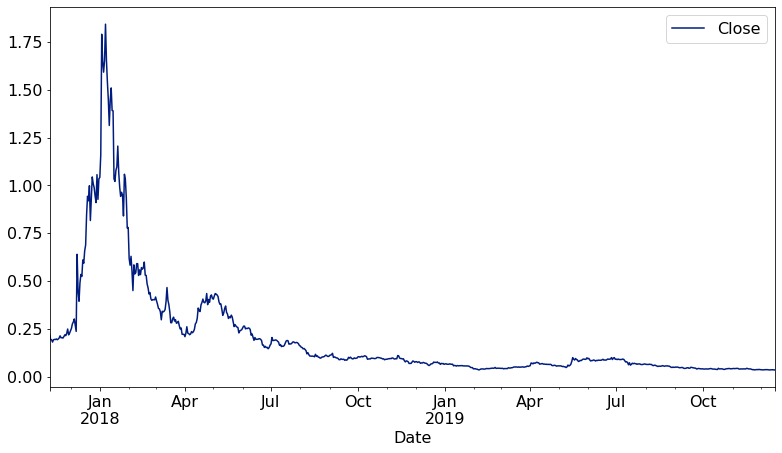

In [134]:
# plot data
nem_train.plot()

**For NEM, I am going to use the simple average for the train data as baseline predictions and will check root mean square error (RMSE) as well as mean average percentage error (MAPE) to evaluate my models**

In [135]:
# predict using mean of train close data
close = nem_train.Close.mean()

yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

In [136]:
round(nem_train.Close.mean(), 5)

0.19978

Baseline Prediction RMSE: 0.15864
Baseline Prediction MAPE: 220


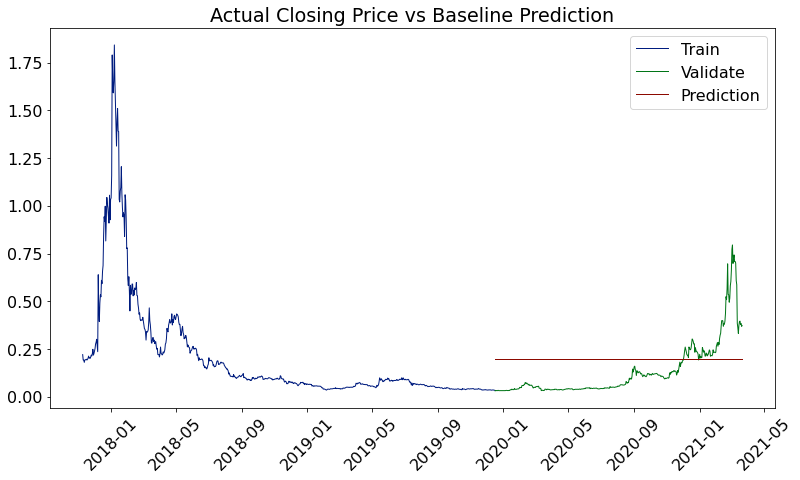

In [137]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'Baseline Prediction')

In [138]:
nem_train.columns

Index(['Close'], dtype='object')

In [139]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'nem_baseline')
eval_df

,model,rmse,mape
0,baseline,0.15864,220


### For any model to be of value, it must beat the baseline RMSE

### Make predictions using moving average and evaluate

In [140]:
# First try 30 day rolling average and use the most recent/last 30 day period value to predict forward. 
close = round(nem_train.Close.rolling(30).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

30day_rolling_avg RMSE: 0.1729
30day_rolling_avg MAPE: 46


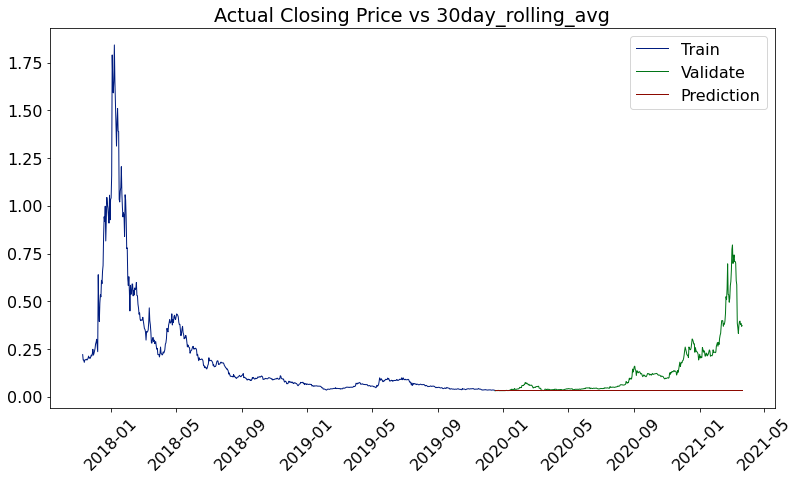

In [141]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, '30day_rolling_avg')

In [142]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'nem_30day_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46


In [143]:
# Next try 7 day rolling average and use the most recent/last 7 day period value to predict forward. 
close = round(nem_train.Close.rolling(7).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

7day_rolling_avg RMSE: 0.17367
7day_rolling_avg MAPE: 47


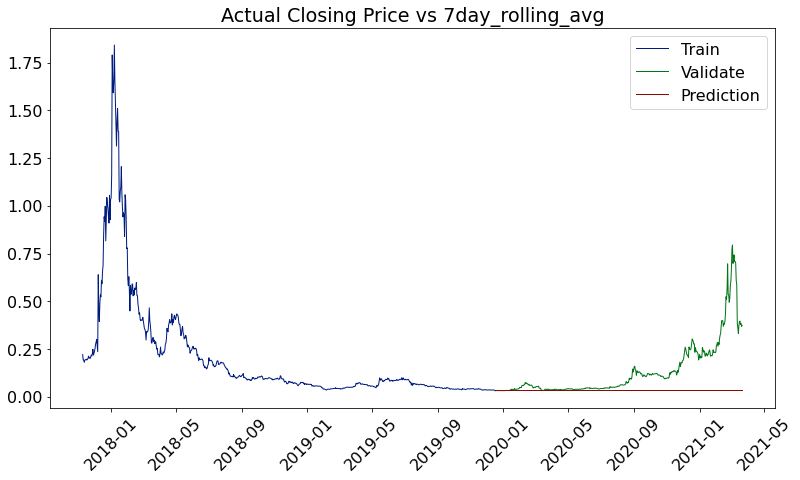

In [144]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, '7day_rolling_avg')

In [145]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'nem_7day_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47


In [146]:
# Next try 365 day rolling average and use the most recent/last 365 day period value to predict forward. 
close = round(nem_train.Close.rolling(365).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

365day_rolling_avg RMSE: 0.16246
365day_rolling_avg MAPE: 50


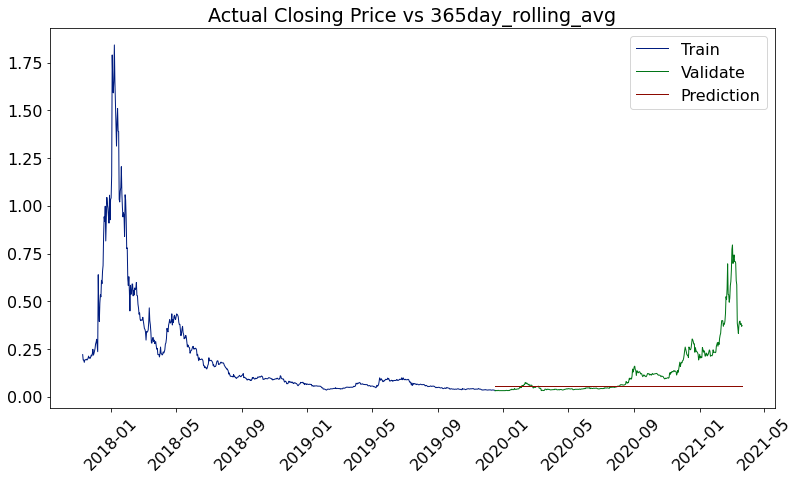

In [147]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, '365day_rolling_avg')

In [148]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'nem_365day_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50


### Make predictions using Holt's Linear Trend and evaluate

In [149]:
# create the model
close = Holt(nem_train.Close, exponential = False)
# fit the model
close = close.fit(smoothing_level = .2, smoothing_slope = .9, optimized = True)

# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = nem_validate.index[0], end = nem_validate.index[-1]), 5), columns=['Close'])

Holt's Linear Trend RMSE: 0.198
Holt's Linear Trend MAPE: 73


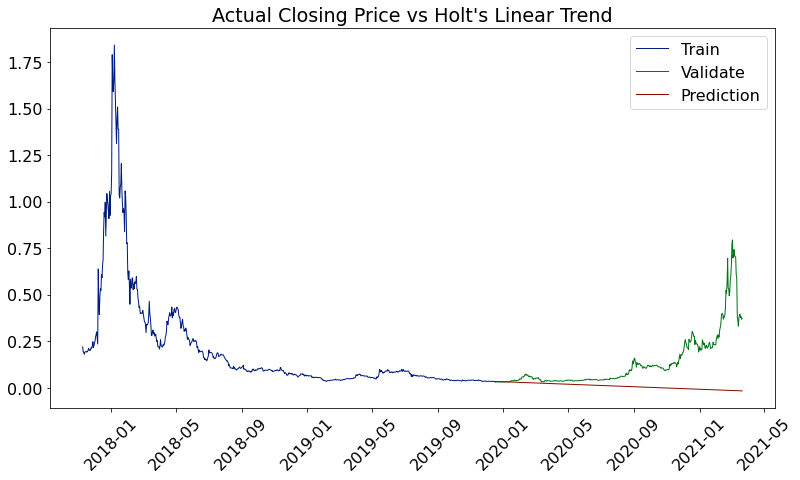

In [150]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'Holt\'s Linear Trend')

**I tried many different values for smoothing_level and smoothing_slope from 0 to 1 and .2 and .9, respectively, produced the best RMSE**

In [151]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'nem_holts_linear_trend')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73


### Make predictions using ARIMA and evaluate

In [152]:
# use iteration to find the best hyperparameter values
p = d = q = range(0, 2)
pdq = list(it.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [153]:
# this code takes a while to run. 
# for param in pdq:
#     for param_model in model_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(nem_train,
#                                             order=param,
#                                             seasonal_order=param_model,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_model, results.aic))
#         except:
#             continue

**Using the code above I discovered order=(0,0,0) to produce the lowest AIC, however, the autocorrelation chart created during explore shows slight correlation with 5 lag periods so I tried order=(5,0,0) as well and it produced a lower RMSE.**

In [154]:
# create the model
close = ARIMA(nem_train.Close, order=(5,0,0))
# fit the model
close = close.fit()
# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = nem_validate.index[0], end = nem_validate.index[-1]), 5), columns=['Close'])

ARIMA RMSE: 0.13118
ARIMA MAPE: 124


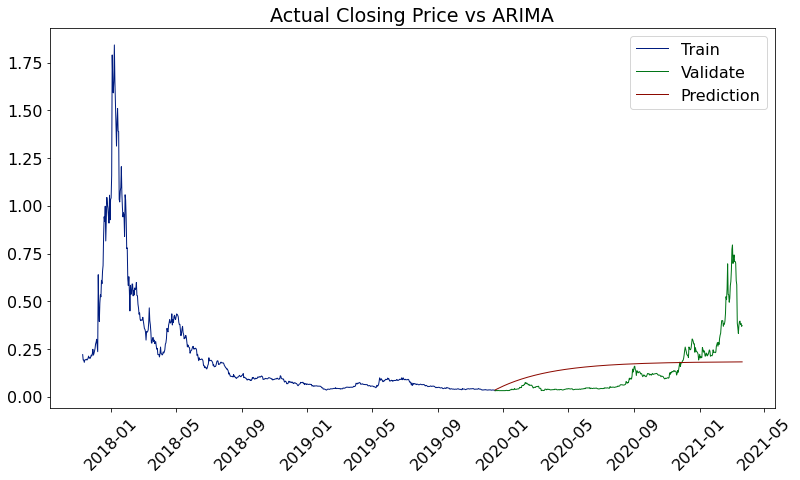

In [155]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'ARIMA')

In [156]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'nem_arima')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124


### Make predictions using FB Prophet and evaluate

In [157]:
# adjust columns for model
df = nem_train.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
predict_df = nem_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

In [158]:
predict_df.head()

,ds
0,2019-12-17
1,2019-12-18
2,2019-12-19
3,2019-12-20
4,2019-12-21


In [159]:
# adjust columns for model
df = nem_train.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
predict_df = nem_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

# create the model
close = Prophet()
# fit the model
close = close.fit(df)
# use the model to predict
yhat = close.predict(predict_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


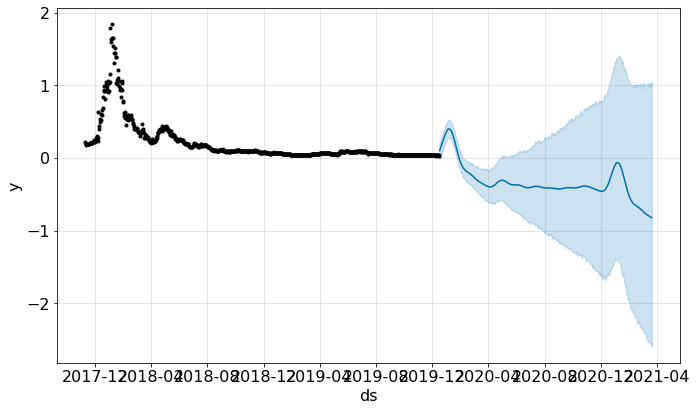

In [160]:
# plot predictions
fig = close.plot(yhat)

In [161]:
# creat interactive chart
from prophet.plot import plot_plotly
plot_plotly(close, yhat)

In [162]:
yhat = pd.DataFrame(yhat.rename(columns={'ds':'Date', 'yhat':'Close'}).set_index('Date').sort_index().loc[:,'Close'])
yhat.head()

,Close
Date,
2019-12-17,0.100104
2019-12-18,0.117281
2019-12-19,0.131302
2019-12-20,0.151256
2019-12-21,0.172799


Prophet RMSE: 0.57361
Prophet MAPE: 602


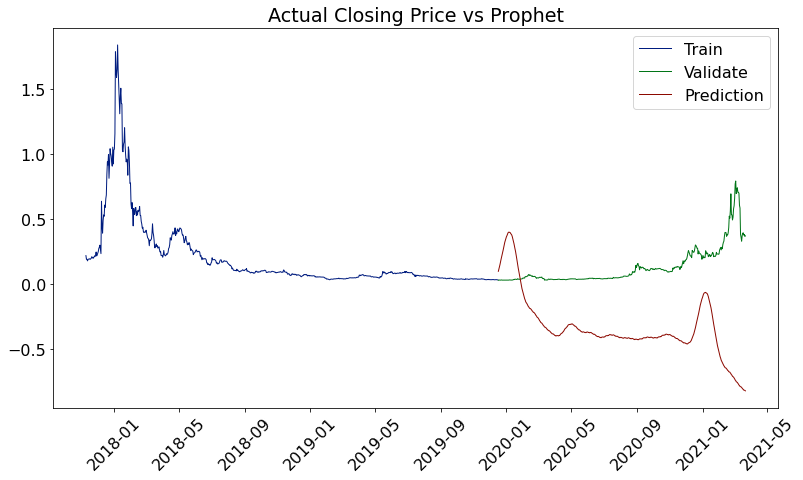

In [163]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, yhat, 'Prophet')

In [164]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_train, nem_validate, yhat, 'nem_prophet')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602


### Establish a baseline model for NEM hourly

<AxesSubplot:>

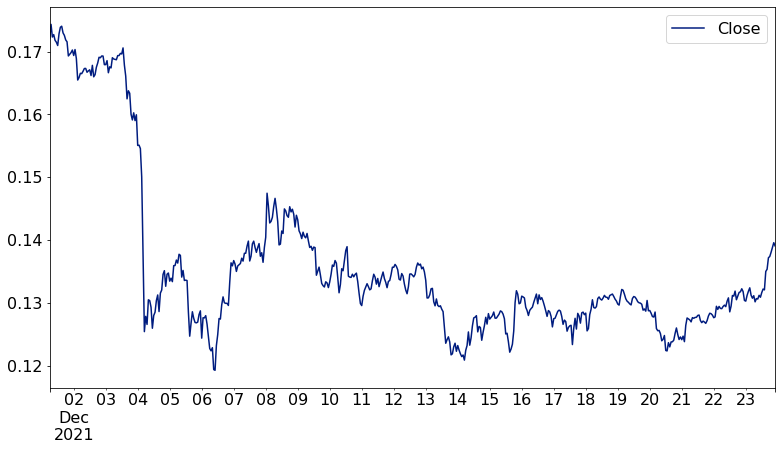

In [165]:
# plot data
nem_hr_train.plot()

## Next I am going to model and evaluate on NEM hourly data

**For NEM hourly, I am going to use the simple average for the train data as baseline predictions and will check root mean square error (RMSE) as well as mean average percentage error (MAPE) to evaluate my models**

In [166]:
# predict using mean of train close data
close = nem_hr_train.Close.mean()

yhat = pd.DataFrame({'Close': [close]}, index = nem_hr_validate.index)

In [167]:
round(nem_hr_train.Close.mean(), 5)

0.13582

Baseline Prediction RMSE: 0.0082
Baseline Prediction MAPE: 6


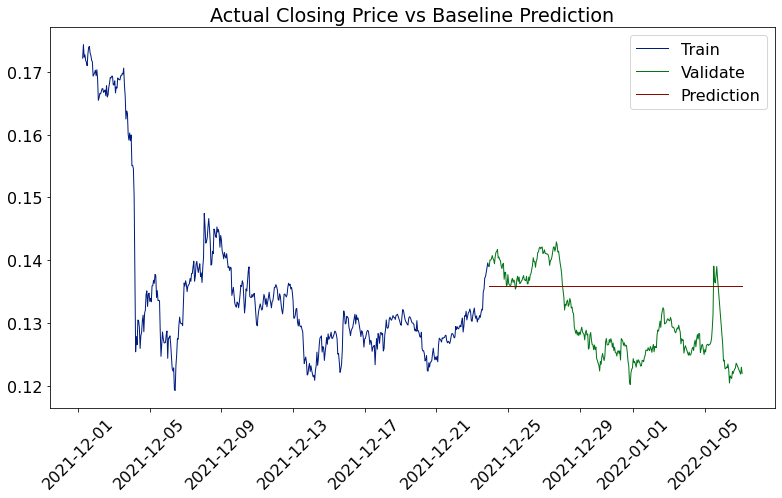

In [168]:
# plot actual vs predicted
plot_and_eval(nem_hr_train, nem_hr_validate, yhat, 'Baseline Prediction')

In [169]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_hr_train, nem_hr_validate, yhat, 'nem_hr_baseline')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6


### For any model to be of value, it must beat the baseline RMSE

### Make predictions using moving average and evaluate

In [170]:
# First try 8 hour rolling average and use the most recent/last 8 hour period value to predict forward. 
close = round(nem_hr_train.Close.rolling(8).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_hr_validate.index)

8hour_rolling_avg RMSE: 0.00939
8hour_rolling_avg MAPE: 6


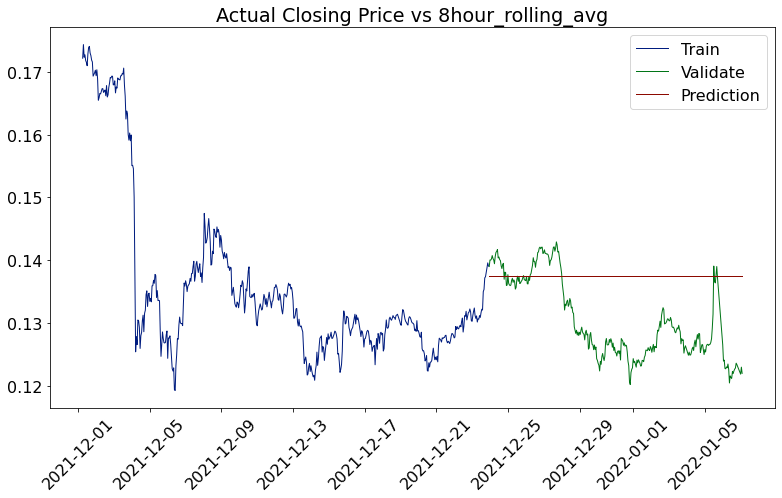

In [171]:
# plot actual vs predicted
plot_and_eval(nem_hr_train, nem_hr_validate, yhat, '8hour_rolling_avg')

In [172]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_hr_train, nem_hr_validate, yhat, 'nem_8hr_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6


In [173]:
# Next try 16 hr rolling average and use the most recent/last 16 hr period value to predict forward. 
close = round(nem_hr_train.Close.rolling(16).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = nem_hr_validate.index)

16hr_rolling_avg RMSE: 0.00737
16hr_rolling_avg MAPE: 5


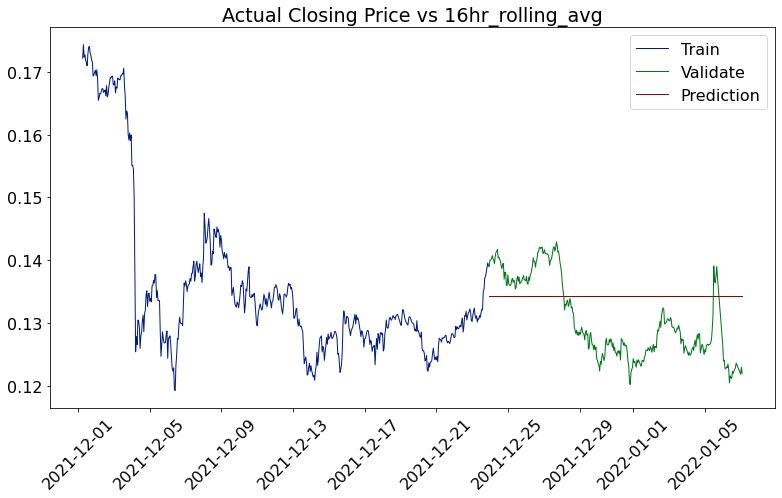

In [174]:
# plot actual vs predicted
plot_and_eval(nem_hr_train, nem_hr_validate, yhat, '16hr_rolling_avg')

In [175]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_hr_train, nem_hr_validate, yhat, '16hr_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


In [176]:
nem_hr_validate.head(2)

,Close
2021-12-23 23:00:00+00:00,0.138993
2021-12-24 00:00:00+00:00,0.140036


In [177]:
nem_hr_validate.index.tz is None

False

In [178]:
# check min and max
nem_hr_validate.index.min(), nem_hr_validate.index.max()

(Timestamp('2021-12-23 23:00:00+0000', tz='UTC'),
 Timestamp('2022-01-07 02:00:00+0000', tz='UTC'))

In [179]:
# create a date range with hourly frequency to compare with nem_hr_validate
my_range = pd.date_range(start='2021-12-23 23:00:00+0000', end='2022-01-07 02:00:00+0000', freq='H')

In [180]:
# check where there are dates/times missing in nem_hr_validate 
print(my_range.difference(nem_hr_validate.index))

DatetimeIndex(['2022-01-03 23:00:00+00:00', '2022-01-04 00:00:00+00:00',
               '2022-01-04 01:00:00+00:00', '2022-01-05 18:00:00+00:00',
               '2022-01-05 19:00:00+00:00', '2022-01-05 20:00:00+00:00',
               '2022-01-05 21:00:00+00:00', '2022-01-05 22:00:00+00:00',
               '2022-01-05 23:00:00+00:00', '2022-01-06 20:00:00+00:00',
               '2022-01-06 21:00:00+00:00', '2022-01-06 22:00:00+00:00',
               '2022-01-06 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [181]:
# turn my_range into a dataframe with a date column
my_range = pd.DataFrame(my_range)
my_range = my_range.rename(columns={0:'Date'})

In [182]:
# set date column as index
my_range = my_range.set_index('Date')

In [183]:
# merge my_range and nem_hr_validate
nem_hr_validate2 = my_range.merge(nem_hr_validate, how='left', left_index=True, right_index=True)
nem_hr_validate2

,Close
Date,
2021-12-23 23:00:00+00:00,0.138993
2021-12-24 00:00:00+00:00,0.140036
2021-12-24 01:00:00+00:00,0.140013
2021-12-24 02:00:00+00:00,0.140211
2021-12-24 03:00:00+00:00,0.140742
...,...
2022-01-06 22:00:00+00:00,NaN
2022-01-06 23:00:00+00:00,NaN
2022-01-07 00:00:00+00:00,0.121859


In [184]:
# use forward fill to fill in missing values
nem_hr_validate2.ffill(axis=0, inplace=True)

In [185]:
# check that all nulls are filled
nem_hr_validate2.isnull().sum()

Close    0
dtype: int64

In [186]:
nem_hr_validate = nem_hr_validate2.copy()
nem_hr_validate

,Close
Date,
2021-12-23 23:00:00+00:00,0.138993
2021-12-24 00:00:00+00:00,0.140036
2021-12-24 01:00:00+00:00,0.140013
2021-12-24 02:00:00+00:00,0.140211
2021-12-24 03:00:00+00:00,0.140742
...,...
2022-01-06 22:00:00+00:00,0.123370
2022-01-06 23:00:00+00:00,0.123370
2022-01-07 00:00:00+00:00,0.121859


In [187]:
nem_hr_validate.index.tz is None

False

### Make predictions using Holt's Linear Trend and evaluate

In [188]:
# create the model
close = Holt(nem_hr_train.Close, exponential = False)
# fit the model
close = close.fit(smoothing_level = .7, smoothing_slope = .9, optimized = True)

# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = nem_hr_validate.index[0], end = nem_hr_validate.index[-1]), 5), columns=['Close'])

Holt's Linear Trend RMSE: 0.00953
Holt's Linear Trend MAPE: 6


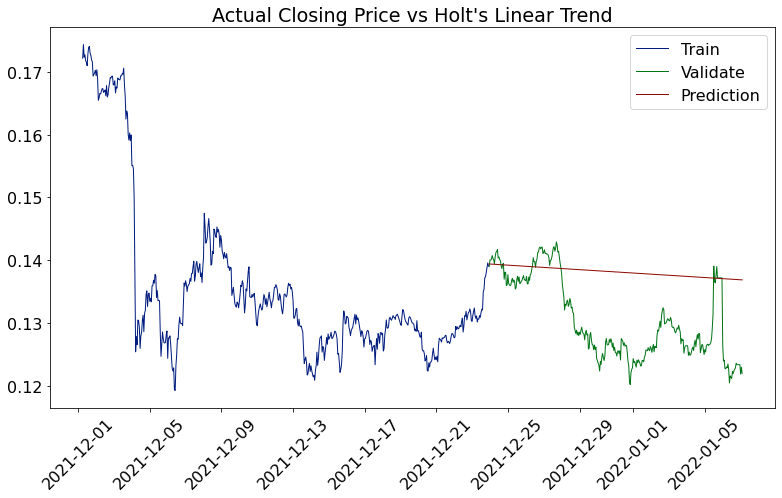

In [189]:
# plot actual vs predicted
plot_and_eval(nem_hr_train, nem_hr_validate, yhat, 'Holt\'s Linear Trend')

**I tried many different values for smoothing_level and smoothing_slope from 0 to 1 and .7 and .9, respectively, produced the best RMSE**

In [190]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_hr_train, nem_hr_validate, yhat, 'holts_linear_trend')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### Make predictions using ARIMA and evaluate

In [191]:
# use iteration to find the best hyperparameter values
p = d = q = range(0, 2)
pdq = list(it.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [192]:
# create the model
close = ARIMA(nem_hr_train.Close, order=(0,0,0))
# fit the model
close = close.fit()
# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = nem_hr_validate.index[0], end = nem_hr_validate.index[-1]), 5), columns=['Close'])

ARIMA RMSE: 0.00821
ARIMA MAPE: 6


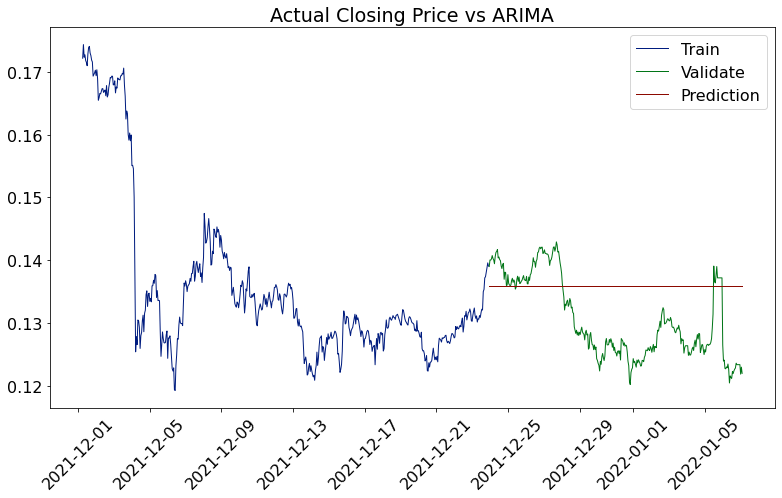

In [193]:
# plot actual vs predicted
plot_and_eval(nem_hr_train, nem_hr_validate, yhat, 'ARIMA')

In [194]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_hr_train, nem_hr_validate, yhat, 'nem_hr_arima')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### Make predictions using FB Prophet and evaluate

In [195]:
# adjust columns for model
df = nem_hr_train.reset_index().rename(columns={'index':'ds', 'Close':'y'})
predict_df = nem_hr_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

In [196]:
# remove timezone
df.ds = df.ds.dt.tz_localize(None)
predict_df.ds = predict_df.ds.dt.tz_localize(None)

In [197]:
# create the model
close = Prophet()
# fit the model
close = close.fit(df)
# use the model to predict
yhat = close.predict(predict_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


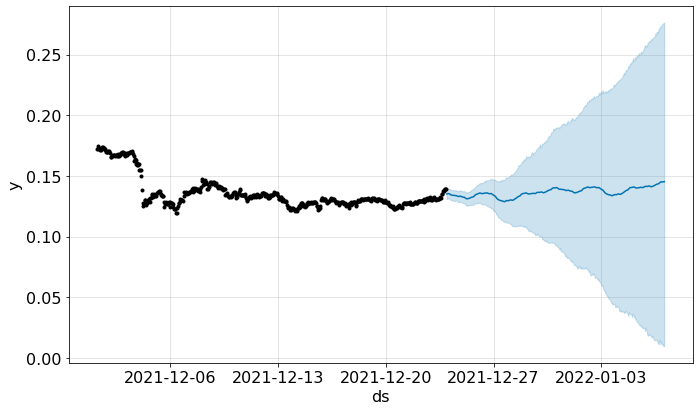

In [198]:
# plot predictions
fig = close.plot(yhat)

In [199]:
# creat interactive chart
from prophet.plot import plot_plotly
plot_plotly(close, yhat)

In [200]:
yhat = pd.DataFrame(yhat.rename(columns={'ds':'Date', 'yhat':'Close'}).set_index('Date').sort_index().loc[:,'Close'])
yhat.head()

,Close
Date,
2021-12-23 23:00:00,0.135102
2021-12-24 00:00:00,0.135185
2021-12-24 01:00:00,0.135341
2021-12-24 02:00:00,0.135400
2021-12-24 03:00:00,0.135226


In [201]:
yhat.index.tz is None

True

In [202]:
nem_hr_train.index = nem_hr_train.index.tz_localize(None)
nem_hr_validate.index = nem_hr_validate.index.tz_localize(None)

In [204]:
nem_hr_validate.index.tz is None

True

Prophet RMSE: 0.01084
Prophet MAPE: 7


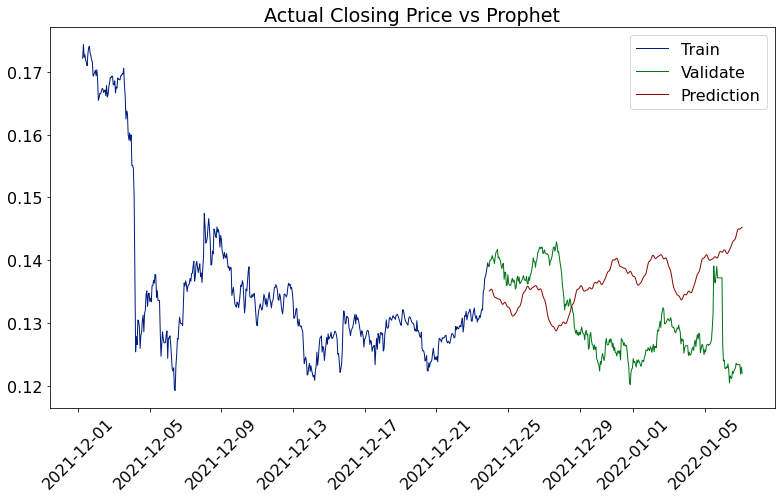

In [205]:
# plot actual vs predicted
plot_and_eval(nem_hr_train, nem_hr_validate, yhat, 'Prophet')

In [207]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, nem_hr_train, nem_hr_validate, yhat, 'nem_hr_prophet')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


## Next I am going to model and evaluate on HOLO daily data

**For HOLO, I am also going to use the simple average for the train data as baseline predictions and will check root mean square error (RMSE) as well as mean average percentage error (MAPE) to evaluate my models**

In [208]:
# predict using mean of train close data
close = holo_train.Close.mean()

yhat = pd.DataFrame({'Close': [close]}, index = holo_validate.index)

In [209]:
round(holo_train.Close.mean(), 5)

0.00097

Baseline Prediction RMSE: 0.00495
Baseline Prediction MAPE: 80


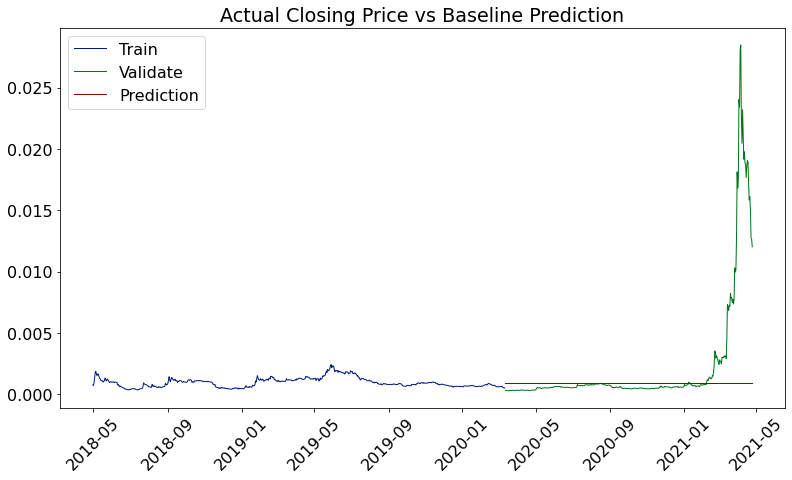

In [210]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, yhat, 'Baseline Prediction')

In [211]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_train, holo_validate, yhat, 'holo_baseline')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### For any model to be of value, it must beat the baseline RMSE

### Make predictions using moving average and evaluate

In [212]:
# First try 30 day rolling average and use the most recent/last 30 day period value to predict forward. 
close = round(holo_train.Close.rolling(30).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = holo_validate.index)

30day_rolling_avg RMSE: 0.00503
30day_rolling_avg MAPE: 45


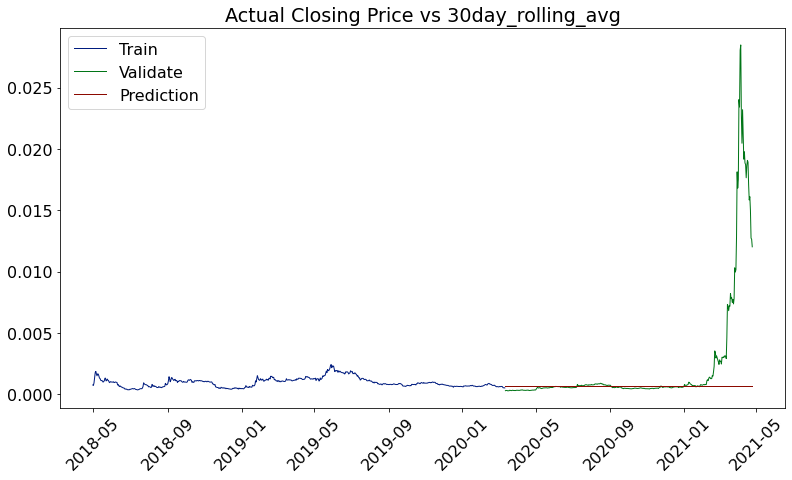

In [213]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, yhat, '30day_rolling_avg')

In [214]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_train, holo_validate, yhat, 'holo_30day_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


In [215]:
# Next try 7 day rolling average and use the most recent/last 7 day period value to predict forward. 
close = round(holo_train.Close.rolling(7).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = holo_validate.index)

7day_rolling_avg RMSE: 0.00506
7day_rolling_avg MAPE: 35


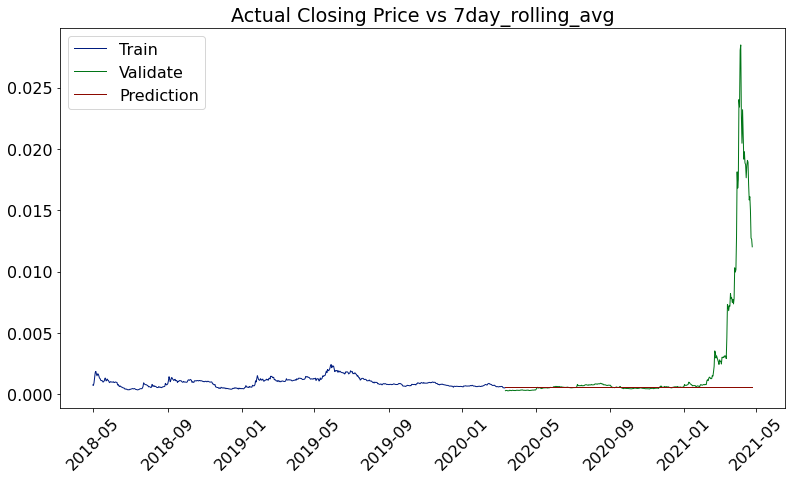

In [216]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, yhat, '7day_rolling_avg')

In [217]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_train, holo_validate, yhat, 'holo_7day_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


In [218]:
# Next try 365 day rolling average and use the most recent/last 365 day period value to predict forward. 
close = round(holo_train.Close.rolling(365).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = holo_validate.index)

365day_rolling_avg RMSE: 0.00493
365day_rolling_avg MAPE: 94


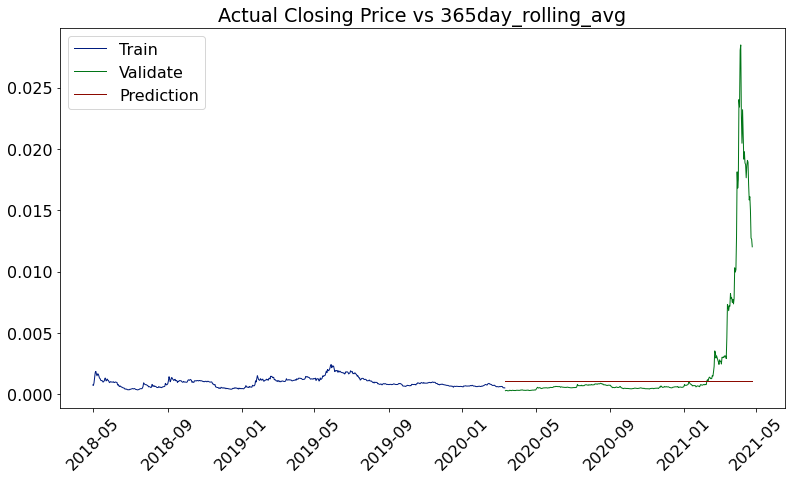

In [219]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, yhat, '365day_rolling_avg')

In [220]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_train, holo_validate, yhat, 'holo_365day_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### Make predictions using Holt's Linear Trend and evaluate

In [261]:
# create the model
close = Holt(holo_train.Close, exponential = False)
# fit the model
close = close.fit(smoothing_level = .7, smoothing_slope = .9, optimized = True)

# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = holo_validate.index[0], end = holo_validate.index[-1]), 5), columns=['Close'])

Holt's Linear Trend RMSE: 0.00568
Holt's Linear Trend MAPE: 128


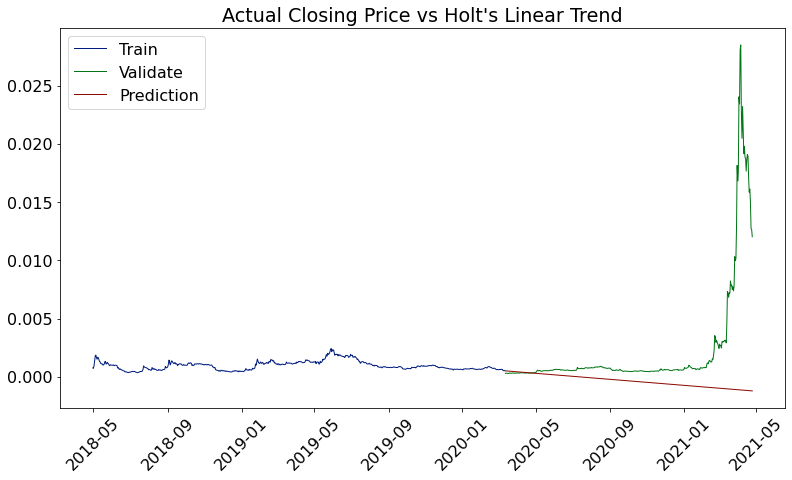

In [262]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, yhat, 'Holt\'s Linear Trend')

**I tried many different values for smoothing_level and smoothing_slope from 0 to 1 and .7 and .9, respectively, produced the best RMSE**

In [263]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_train, holo_validate, yhat, 'holts_linear_trend')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### Make predictions using ARIMA and evaluate

In [297]:
# create the model
close = ARIMA(holo_train.Close, order=(5,0,3))
# fit the model
close = close.fit()
# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = holo_validate.index[0], end = holo_validate.index[-1]), 5), columns=['Close'])

ARIMA RMSE: 0.00496
ARIMA MAPE: 56


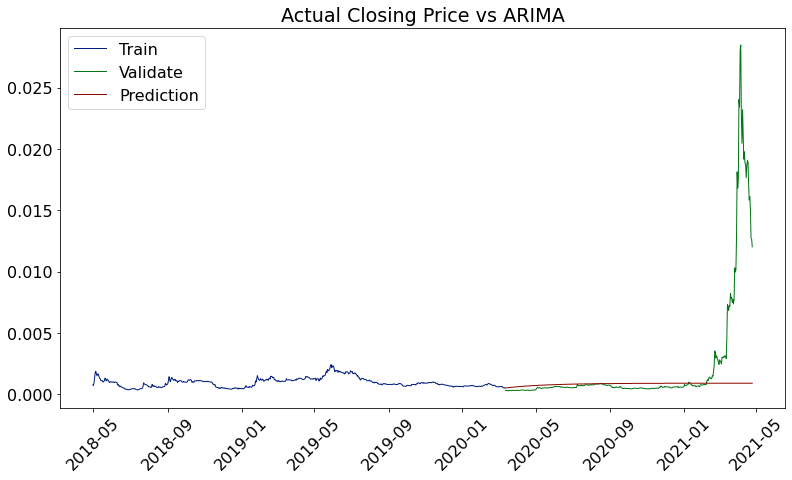

In [298]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, yhat, 'ARIMA')

In [299]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_train, holo_validate, yhat, 'holo_arima')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### Make predictions using FB Prophet and evaluate

In [300]:
# adjust columns for model
df = holo_train.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
predict_df = holo_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

In [301]:
# adjust columns for model
df = holo_train.reset_index().rename(columns={'Date':'ds', 'Close':'y'})
predict_df = holo_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

# create the model
close = Prophet()
# fit the model
close = close.fit(df)
# use the model to predict
yhat = close.predict(predict_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


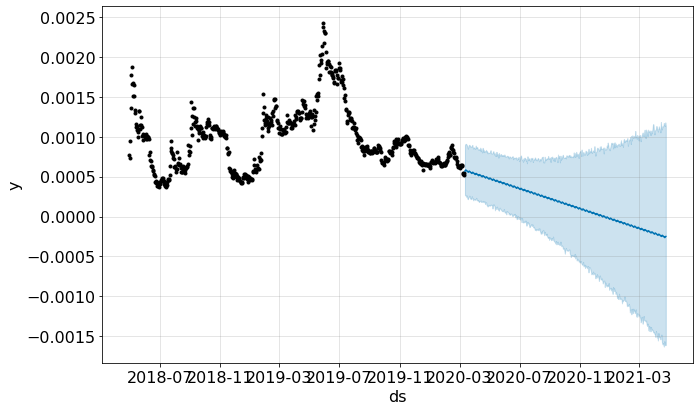

In [302]:
# plot predictions
fig = close.plot(yhat)

In [303]:
# creat interactive chart
from prophet.plot import plot_plotly
plot_plotly(close, yhat)

In [304]:
yhat = pd.DataFrame(yhat.rename(columns={'ds':'Date', 'yhat':'Close'}).set_index('Date').sort_index().loc[:,'Close'])
yhat.head()

,Close
Date,
2020-03-12,0.000569
2020-03-13,0.000580
2020-03-14,0.000583
2020-03-15,0.000575
2020-03-16,0.000573


Prophet RMSE: 0.00534
Prophet MAPE: 74


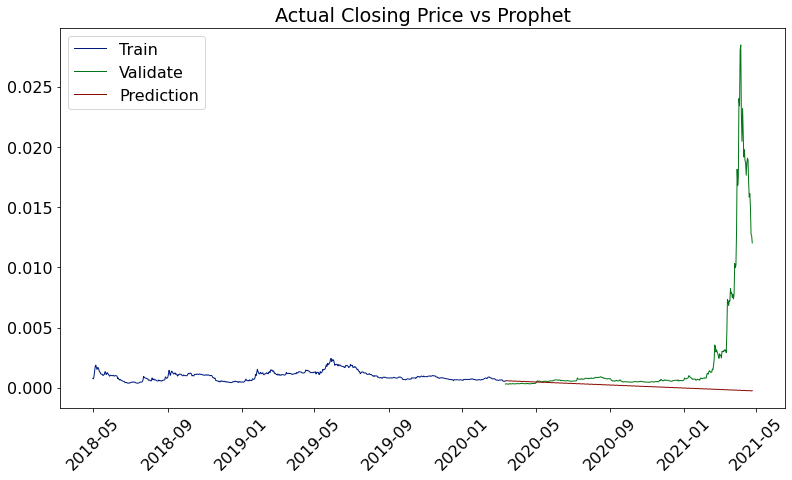

In [305]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, yhat, 'Prophet')

In [306]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_train, holo_validate, yhat, 'holo_prophet')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


## Finally, I will model and evaluate HOLO hourly data

### Establish a baseline model for HOLO hourly

<AxesSubplot:>

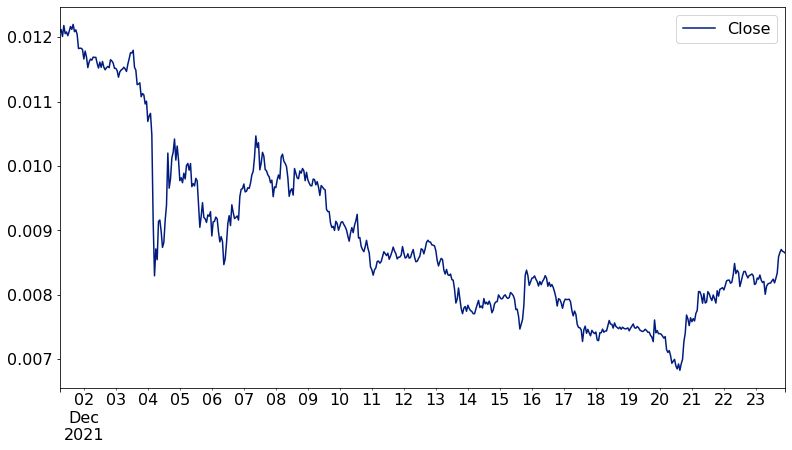

In [307]:
# plot data
holo_hr_train.plot()

**For HOLO hourly, I am also going to use the simple average for the train data as baseline predictions and will check root mean square error (RMSE) as well as mean average percentage error (MAPE) to evaluate my models**

In [308]:
# predict using mean of train close data
close = holo_hr_train.Close.mean()

yhat = pd.DataFrame({'Close': [close]}, index = holo_hr_validate.index)

Baseline Prediction RMSE: 0.00128
Baseline Prediction MAPE: 15


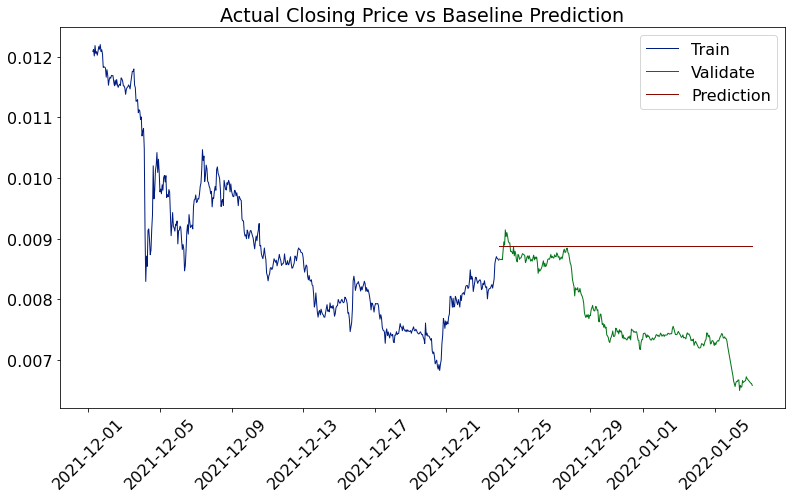

In [309]:
# plot actual vs predicted
plot_and_eval(holo_hr_train, holo_hr_validate, yhat, 'Baseline Prediction')

In [310]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_hr_train, holo_hr_validate, yhat, 'holo_hr_baseline')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### For any model to be of value, it must beat the baseline RMSE

### Make predictions using moving average and evaluate

In [311]:
# First try 8 hour rolling average and use the most recent/last 8 hour period value to predict forward. 
close = round(holo_hr_train.Close.rolling(8).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = holo_hr_validate.index)

8hour_rolling_avg RMSE: 0.00102
8hour_rolling_avg MAPE: 12


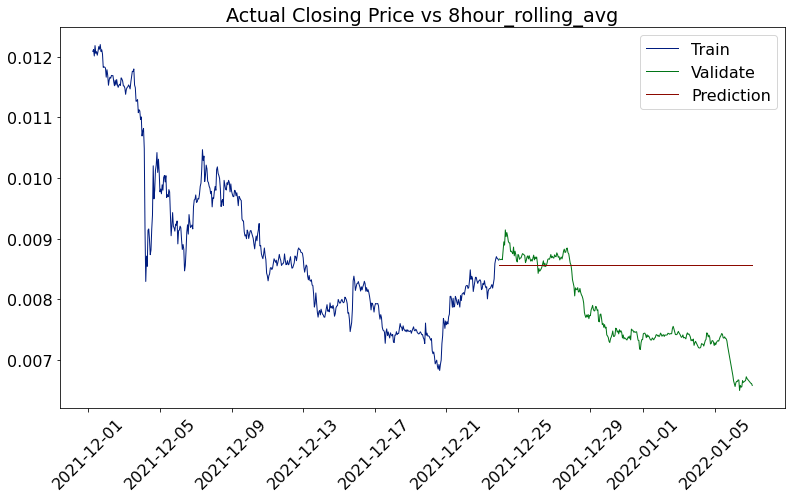

In [312]:
# plot actual vs predicted
plot_and_eval(holo_hr_train, holo_hr_validate, yhat, '8hour_rolling_avg')

In [313]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_hr_train, holo_hr_validate, yhat, 'holo_8hr_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


In [314]:
# Next try 16 hr rolling average and use the most recent/last 16 hr period value to predict forward. 
close = round(holo_hr_train.Close.rolling(16).mean().iloc[-1], 5)

# make predictions
yhat = pd.DataFrame({'Close': [close]}, index = holo_hr_validate.index)

16hr_rolling_avg RMSE: 0.00088
16hr_rolling_avg MAPE: 10


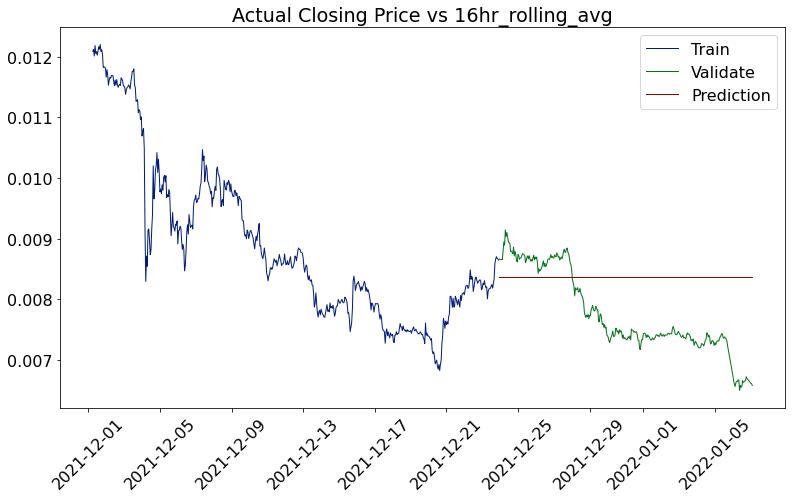

In [315]:
# plot actual vs predicted
plot_and_eval(holo_hr_train, holo_hr_validate, yhat, '16hr_rolling_avg')

In [316]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_hr_train, holo_hr_validate, yhat, 'holo_16hr_rolling_avg')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


In [317]:
holo_hr_validate.head(2)

,Close
2021-12-23 23:00:00+00:00,0.008666
2021-12-24 00:00:00+00:00,0.008655


In [318]:
holo_hr_validate.index.tz is None

False

In [319]:
# check min and max
holo_hr_validate.index.min(), holo_hr_validate.index.max()

(Timestamp('2021-12-23 23:00:00+0000', tz='UTC'),
 Timestamp('2022-01-07 02:00:00+0000', tz='UTC'))

In [320]:
# create a date range with hourly frequency to compare with nem_hr_validate
my_range = pd.date_range(start='2021-12-23 23:00:00+0000', end='2022-01-07 02:00:00+0000', freq='H')

In [322]:
# check where there are dates/times missing in holo_hr_validate 
print(my_range.difference(holo_hr_validate.index))

DatetimeIndex(['2022-01-03 23:00:00+00:00', '2022-01-04 00:00:00+00:00',
               '2022-01-04 01:00:00+00:00', '2022-01-05 18:00:00+00:00',
               '2022-01-05 19:00:00+00:00', '2022-01-05 20:00:00+00:00',
               '2022-01-05 21:00:00+00:00', '2022-01-05 22:00:00+00:00',
               '2022-01-05 23:00:00+00:00', '2022-01-06 20:00:00+00:00',
               '2022-01-06 21:00:00+00:00', '2022-01-06 22:00:00+00:00',
               '2022-01-06 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [323]:
# turn my_range into a dataframe with a date column
my_range = pd.DataFrame(my_range)
my_range = my_range.rename(columns={0:'Date'})

In [324]:
# set date column as index
my_range = my_range.set_index('Date')

In [325]:
# merge my_range and nem_hr_validate
holo_hr_validate2 = my_range.merge(holo_hr_validate, how='left', left_index=True, right_index=True)
holo_hr_validate2

,Close
Date,
2021-12-23 23:00:00+00:00,0.008666
2021-12-24 00:00:00+00:00,0.008655
2021-12-24 01:00:00+00:00,0.008659
2021-12-24 02:00:00+00:00,0.008661
2021-12-24 03:00:00+00:00,0.008655
...,...
2022-01-06 22:00:00+00:00,NaN
2022-01-06 23:00:00+00:00,NaN
2022-01-07 00:00:00+00:00,0.006618


In [326]:
# use forward fill to fill in missing values
holo_hr_validate2.ffill(axis=0, inplace=True)

In [327]:
# check that all nulls are filled
holo_hr_validate2.isnull().sum()

Close    0
dtype: int64

In [328]:
holo_hr_validate = holo_hr_validate2.copy()
holo_hr_validate

,Close
Date,
2021-12-23 23:00:00+00:00,0.008666
2021-12-24 00:00:00+00:00,0.008655
2021-12-24 01:00:00+00:00,0.008659
2021-12-24 02:00:00+00:00,0.008661
2021-12-24 03:00:00+00:00,0.008655
...,...
2022-01-06 22:00:00+00:00,0.006695
2022-01-06 23:00:00+00:00,0.006695
2022-01-07 00:00:00+00:00,0.006618


In [330]:
holo_hr_train.index = holo_hr_train.index.tz_localize(None)
holo_hr_validate.index = holo_hr_validate.index.tz_localize(None)

In [331]:
holo_hr_validate.index.tz is None

True

### Make predictions using Holt's Linear Trend and evaluate

In [354]:
# create the model
close = Holt(holo_hr_train.Close, exponential = False)
# fit the model
close = close.fit(smoothing_level = .9, smoothing_slope = .5, optimized = True)

# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = holo_hr_validate.index[0], end = holo_hr_validate.index[-1]), 5), columns=['Close'])

Holt's Linear Trend RMSE: 0.00049
Holt's Linear Trend MAPE: 5


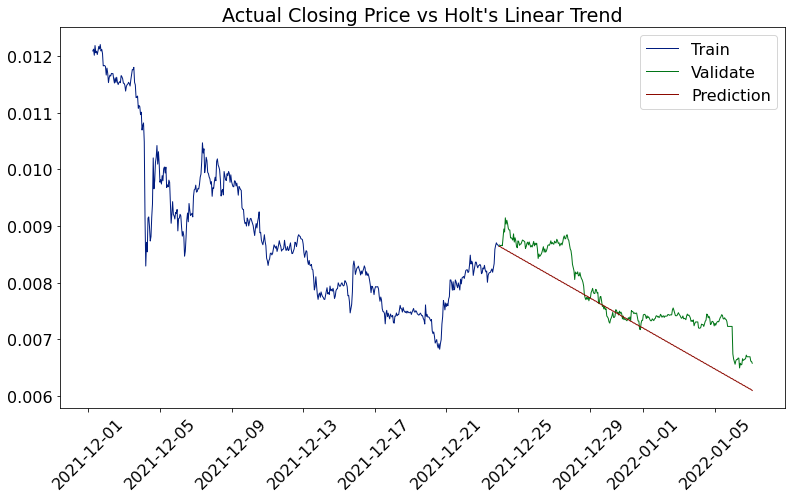

In [355]:
# plot actual vs predicted
plot_and_eval(holo_hr_train, holo_hr_validate, yhat, 'Holt\'s Linear Trend')

**I tried many different values for smoothing_level and smoothing_slope from 0 to 1 and .9 and .5, respectively, produced the best RMSE**

In [356]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_hr_train, holo_hr_validate, yhat, 'holo_hr_holts_linear_trend')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### Make predictions using ARIMA and evaluate

In [382]:
# create the model
close = ARIMA(holo_hr_train.Close, order=(0,0,0))
# fit the model
close = close.fit()
# use the model to predict
yhat = pd.DataFrame(round(close.predict(start = holo_hr_validate.index[0], end = holo_hr_validate.index[-1]), 5), columns=['Close'])

ARIMA RMSE: 0.00131
ARIMA MAPE: 15


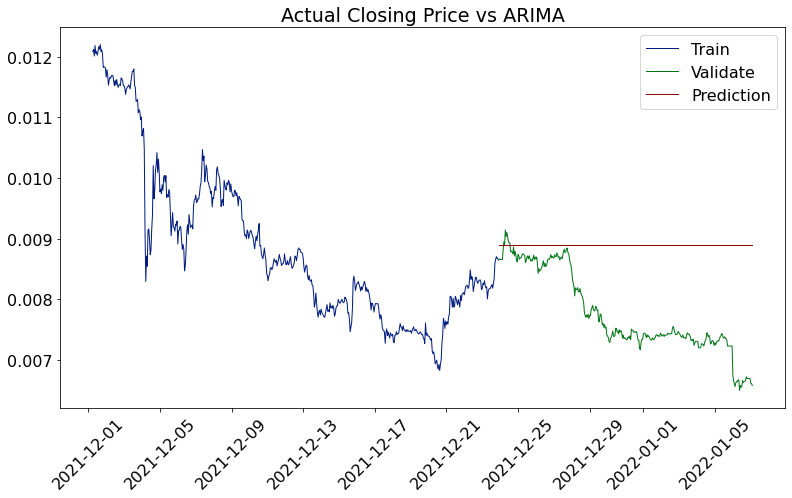

In [383]:
# plot actual vs predicted
plot_and_eval(holo_hr_train, holo_hr_validate, yhat, 'ARIMA')

In [384]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_hr_train, holo_hr_validate, yhat, 'holo_hr_arima')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5


### Make predictions using FB Prophet and evaluate

In [385]:
# adjust columns for model
df = holo_hr_train.reset_index().rename(columns={'index':'ds', 'Close':'y'})
predict_df = holo_hr_validate.reset_index().drop(columns='Close').rename(columns={'Date':'ds'})

In [386]:
# create the model
close = Prophet()
# fit the model
close = close.fit(df)
# use the model to predict
yhat = close.predict(predict_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


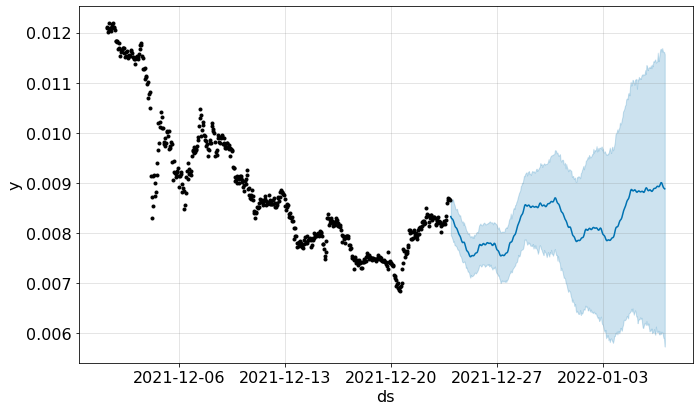

In [387]:
# plot predictions
fig = close.plot(yhat)

In [388]:
# creat interactive chart
from prophet.plot import plot_plotly
plot_plotly(close, yhat)

In [389]:
yhat = pd.DataFrame(yhat.rename(columns={'ds':'Date', 'yhat':'Close'}).set_index('Date').sort_index().loc[:,'Close'])
yhat.head()

,Close
Date,
2021-12-23 23:00:00,0.008325
2021-12-24 00:00:00,0.008294
2021-12-24 01:00:00,0.008280
2021-12-24 02:00:00,0.008269
2021-12-24 03:00:00,0.008245


Prophet RMSE: 0.00112
Prophet MAPE: 13


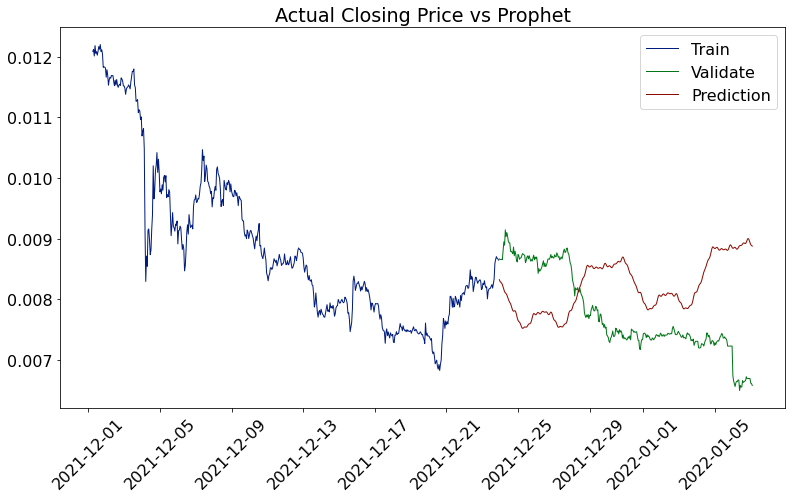

In [391]:
# plot actual vs predicted
plot_and_eval(holo_hr_train, holo_hr_validate, yhat, 'Prophet')

In [392]:
# append metrics to evaluate dataframe
eval_df = append_eval_df(eval_df, holo_hr_train, holo_hr_validate, yhat, 'holo_hr_prophet')
eval_df

,model,rmse,mape
0,baseline,0.15864,220
1,30day_rolling_avg,0.17290,46
2,7day_rolling_avg,0.17367,47
3,365day_rolling_avg,0.16246,50
4,holts_linear_trend,0.19800,73
5,arima,0.13118,124
6,prophet,0.57361,602
7,nem_hr_baseline,0.00820,6
8,nem_8hr_rolling_avg,0.00939,6
9,16hr_rolling_avg,0.00737,5
